# Exploratory Data Analysis example


### 4 mental buckets

- Outliers, scaling, suspicious data
- Class imbalance
- Oh let's definitely try to include this
- Oh this is probably useless

We're going a series of steps, and chucking the relevant columns into 1 or more of these buckets.
I prefer to keep EDA separate from the actual processing of data after the decisions have been made to not waste resources/time replotting on each iteration.

In [1]:
# import libraries

# %pip install -r requirements.txt

# general wrangling
import pandas as pd
import numpy as np
import missingno

# visualisations
import seaborn as sns
import matplotlib.pyplot as plt

# interactive widgets on jupyter
import ipywidgets as widgets
from ipywidgets import interact

# pandas eda report
import pandas_profiling

# For my legacy sns function
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

# "Collecting" data

```SQL
select 
columns_ingested 
from fact_table
left join 
all_other_dim_tables on relevant_keys
```

In [2]:
df = pd.read_csv(r"travel_insurance.csv", encoding="utf-8")
df.columns = [x.replace("(", "").replace(")", "").replace(" ", "_").lower() for x in df.columns]
df.head()

agency    agency_type distribution_channel                     product_name  \
0    CBH  Travel Agency              Offline               Comprehensive Plan   
1    CBH  Travel Agency              Offline               Comprehensive Plan   
2    CWT  Travel Agency               Online  Rental Vehicle Excess Insurance   
3    CWT  Travel Agency               Online  Rental Vehicle Excess Insurance   
4    CWT  Travel Agency               Online  Rental Vehicle Excess Insurance   

  claim  duration destination  net_sales  commision_in_value gender  age  
0    No       186    MALAYSIA      -29.0                9.57      F   81  
1    No       186    MALAYSIA      -29.0                9.57      F   71  
2    No        65   AUSTRALIA      -49.5               29.70    NaN   32  
3    No        60   AUSTRALIA      -39.6               23.76    NaN   32  
4    No        79       ITALY      -19.8               11.88    NaN   41

# General intuition for data

- A library like pandas provides tons of useful methods and functions for getting data summaries
- It is recommended to keep a repository of useful UDFs to reuse as not all inbuilt functions are fit for purpose
- It would be extremely useful to have a utils repository containing all the reusable UDFs written over time that is catered to your requirements

In [3]:
df.describe().T.round(3)

# the .describe() is a great way to get a high-level view of the distribution of the numerical features
# Note duration, age, net_sales into the sus bucket instantly

count    mean      std    min   25%    50%    75%  \
duration            63326.0  49.317  101.792   -2.0   9.0  22.00  53.00   
net_sales           63326.0  40.702   48.846 -389.0  18.0  26.53  48.00   
commision_in_value  63326.0   9.810   19.804    0.0   0.0   0.00  11.55   
age                 63326.0  39.970   14.017    0.0  35.0  36.00  43.00   

                       max  
duration            4881.0  
net_sales            810.0  
commision_in_value   283.5  
age                  118.0

In [4]:
# Example of a reusable UDF

def col_cat_info(df: pd.DataFrame, col: str) -> dict:
    '''
        Function takes in a string representing the column name and returns information:
        - name of column
        - number of categories
        - unique categories
        - proportion of points for each category
        in a json obj.
    '''
    try: 
        cat_col = df[col]
    except KeyError:
        return "Column not found"
    return {
        "name": col,
        "num_of_cat": len(df[col].unique()),
        "categories": df[col].unique(),
        "ppn": { (k, np.round(df.loc[df[col] == k, :][col].count() / df.shape[0], 2)) for k in df[col].unique() }
    }

In [5]:
print(col_cat_info(df, "claim"))
print(col_cat_info(df, "agency_type"))
print(col_cat_info(df, "distribution_channel"))

{'name': 'claim', 'num_of_cat': 2, 'categories': array(['No', 'Yes'], dtype=object), 'ppn': {('No', 0.99), ('Yes', 0.01)}}
{'name': 'agency_type', 'num_of_cat': 2, 'categories': array(['Travel Agency', 'Airlines'], dtype=object), 'ppn': {('Airlines', 0.28), ('Travel Agency', 0.72)}}
{'name': 'distribution_channel', 'num_of_cat': 2, 'categories': array(['Offline', 'Online'], dtype=object), 'ppn': {('Offline', 0.02), ('Online', 0.98)}}


In [6]:
df["distribution_channel"] = df["distribution_channel"].map({ "Offline": 0, "Online": 1 })
df["agency_type"] = df["agency_type"].map({ "Travel Agency": 0, "Airlines": 1 })
df["claim"] = df["claim"].map({ "No": 0, "Yes": 1 })

In [7]:
df.describe().T.round(3)
# Probably can throw claim into the imbalance bucket

count    mean      std    min   25%    50%    75%  \
agency_type           63326.0   0.276    0.447    0.0   0.0   0.00   1.00   
distribution_channel  63326.0   0.983    0.131    0.0   1.0   1.00   1.00   
claim                 63326.0   0.015    0.120    0.0   0.0   0.00   0.00   
duration              63326.0  49.317  101.792   -2.0   9.0  22.00  53.00   
net_sales             63326.0  40.702   48.846 -389.0  18.0  26.53  48.00   
commision_in_value    63326.0   9.810   19.804    0.0   0.0   0.00  11.55   
age                   63326.0  39.970   14.017    0.0  35.0  36.00  43.00   

                         max  
agency_type              1.0  
distribution_channel     1.0  
claim                    1.0  
duration              4881.0  
net_sales              810.0  
commision_in_value     283.5  
age                    118.0

In [8]:
# Could be refunds, in reality good to check
# For the purposes of this exercise let's just chuck those rows. ~2k rows

df = df.loc[df["net_sales"] > 0, :]

In [9]:
# Let's tackle the lower bound for duration
# Just based on domain knowledge, could be time differences?
# Could be on-trip purchases?
# Could just be errors?
# This is probably where asking around or diving into confluence/google may help

df.loc[df['duration'] < 0, :]

agency  agency_type  distribution_channel product_name  claim  duration  \
14943    JZI            1                     1   Basic Plan      0        -2   
52587    JZI            1                     1   Basic Plan      0        -1   
52588    JZI            1                     1   Basic Plan      0        -1   
56668    JZI            1                     1   Basic Plan      0        -1   
59528    JZI            1                     1   Basic Plan      0        -1   

             destination  net_sales  commision_in_value gender  age  
14943         BANGLADESH       22.0                 7.7      M  118  
52587           MALAYSIA       18.0                 6.3    NaN  118  
52588  BRUNEI DARUSSALAM       18.0                 6.3    NaN  118  
56668          INDONESIA       18.0                 6.3    NaN  118  
59528              CHINA       22.0                 7.7    NaN  118

In [10]:
df.sort_values(by="duration", ascending=False).head(20)

agency  agency_type  distribution_channel                  product_name  \
3025     SSI            1                     1              Ticket Protector   
6847     SSI            1                     1              Ticket Protector   
8686     SSI            1                     1              Ticket Protector   
9232     SSI            1                     1              Ticket Protector   
12059    SSI            1                     1              Ticket Protector   
12438    SSI            1                     1              Ticket Protector   
15281    SSI            1                     1              Ticket Protector   
21916    SSI            1                     1              Ticket Protector   
30437    SSI            1                     1              Ticket Protector   
30826    SSI            1                     1              Ticket Protector   
39842    SSI            1                     1              Ticket Protector   
41391    SSI            1                     1              Ticket Protector   
49722    SSI            1                     1              Ticket Protector   
55326    SSI            1                     1              Ticket Protector   
24165    C2B            1                     1            Annual Silver Plan   
46303    C2B            1                     1            Annual Silver Plan   
55116    LWC            0                     1  Annual Travel Protect Silver   
36022    LWC            0                     1    Annual Travel Protect Gold   
51153    C2B            1                     1            Annual Silver Plan   
56693    C2B            1                     1            Annual Silver Plan   

       claim  duration    destination  net_sales  commision_in_value gender  \
3025       0      4881      SINGAPORE       0.13                0.04    NaN   
6847       0      4857      SINGAPORE       0.32                0.09    NaN   
8686       0      4847      SINGAPORE       0.32                0.09    NaN   
9232       0      4844      SINGAPORE       0.32                0.09    NaN   
12059      0      4831      SINGAPORE       0.32                0.09    NaN   
12438      0      4829      SINGAPORE       0.32                0.09    NaN   
15281      0      4815      SINGAPORE       0.32                0.09    NaN   
21916      0      4784      SINGAPORE       0.32                0.09    NaN   
30437      0      4738      SINGAPORE       0.32                0.09    NaN   
30826      0      4736      SINGAPORE       0.32                0.09    NaN   
39842      0      4685      SINGAPORE       0.32                0.09    NaN   
41391      0      4652      SINGAPORE       0.32                0.09    NaN   
49722      0      4609      SINGAPORE       0.32                0.09    NaN   
55326      0      4580      SINGAPORE       0.32                0.09    NaN   
24165      0       547      SINGAPORE     252.85               63.21      F   
46303      0       545      SINGAPORE     161.00               40.25      M   
55116      0       531  UNITED STATES     229.80              149.37      F   
36022      0       529  UNITED STATES     256.00              166.40      M   
51153      0       529      SINGAPORE     216.00               54.00      F   
56693      0       519      SINGAPORE     216.00               54.00      F   

       age  
3025    48  
6847    48  
8686    48  
9232    48  
12059   48  
12438   48  
15281   48  
21916   48  
30437   48  
30826   48  
39842   48  
41391   48  
49722   48  
55326   48  
24165   33  
46303   40  
55116   48  
36022   41  
51153   68  
56693   60

In [11]:
# Set any durations < 0 to 1
# For purposes of visualisations let's remove the 4k duration entries
# In reality you'd probably want to check and ask around, though a 12 year duration is ridiculous

df.loc[df["duration"] < 0, "duration"] = 1
df = df.loc[df["duration"] < 4000, :]

In [27]:
# Let's look at age

col_cat_info(df, "age")["ppn"]

{(0.0, 0.0),
 (1.0, 0.0),
 (2.0, 0.0),
 (3.0, 0.0),
 (4.0, 0.0),
 (5.0, 0.0),
 (7.0, 0.0),
 (8.0, 0.0),
 (9.0, 0.0),
 (10.0, 0.0),
 (11.0, 0.0),
 (12.0, 0.0),
 (13.0, 0.0),
 (14.0, 0.0),
 (15.0, 0.0),
 (16.0, 0.0),
 (17.0, 0.0),
 (18.0, 0.0),
 (19.0, 0.0),
 (20.0, 0.0),
 (21.0, 0.01),
 (22.0, 0.01),
 (23.0, 0.01),
 (24.0, 0.01),
 (25.0, 0.01),
 (26.0, 0.02),
 (27.0, 0.02),
 (28.0, 0.02),
 (29.0, 0.02),
 (30.0, 0.02),
 (31.0, 0.04),
 (32.0, 0.02),
 (33.0, 0.02),
 (34.0, 0.02),
 (35.0, 0.04),
 (36.0, 0.39),
 (37.0, 0.02),
 (38.0, 0.01),
 (39.0, 0.01),
 (39.98213991769547, 0.02),
 (40.0, 0.01),
 (41.0, 0.01),
 (42.0, 0.01),
 (43.0, 0.01),
 (44.0, 0.01),
 (45.0, 0.01),
 (46.0, 0.01),
 (47.0, 0.01),
 (48.0, 0.04),
 (49.0, 0.01),
 (50.0, 0.01),
 (51.0, 0.01),
 (52.0, 0.01),
 (53.0, 0.01),
 (54.0, 0.01),
 (55.0, 0.01),
 (56.0, 0.01),
 (57.0, 0.01),
 (58.0, 0.01),
 (59.0, 0.01),
 (60.0, 0.01),
 (61.0, 0.01),
 (62.0, 0.0),
 (63.0, 0.0),
 (64.0, 0.0),
 (65.0, 0.0),
 (66.0, 0.0),
 (67.0, 0.0),
 (

In [13]:
# 984 rows. Not too sure if it is a data error, impute for now with mean

df.loc[df["age"] == 118, :]
df.loc[df["age"] == 118, "age"] = df["age"].mean()

0.7072098765432099


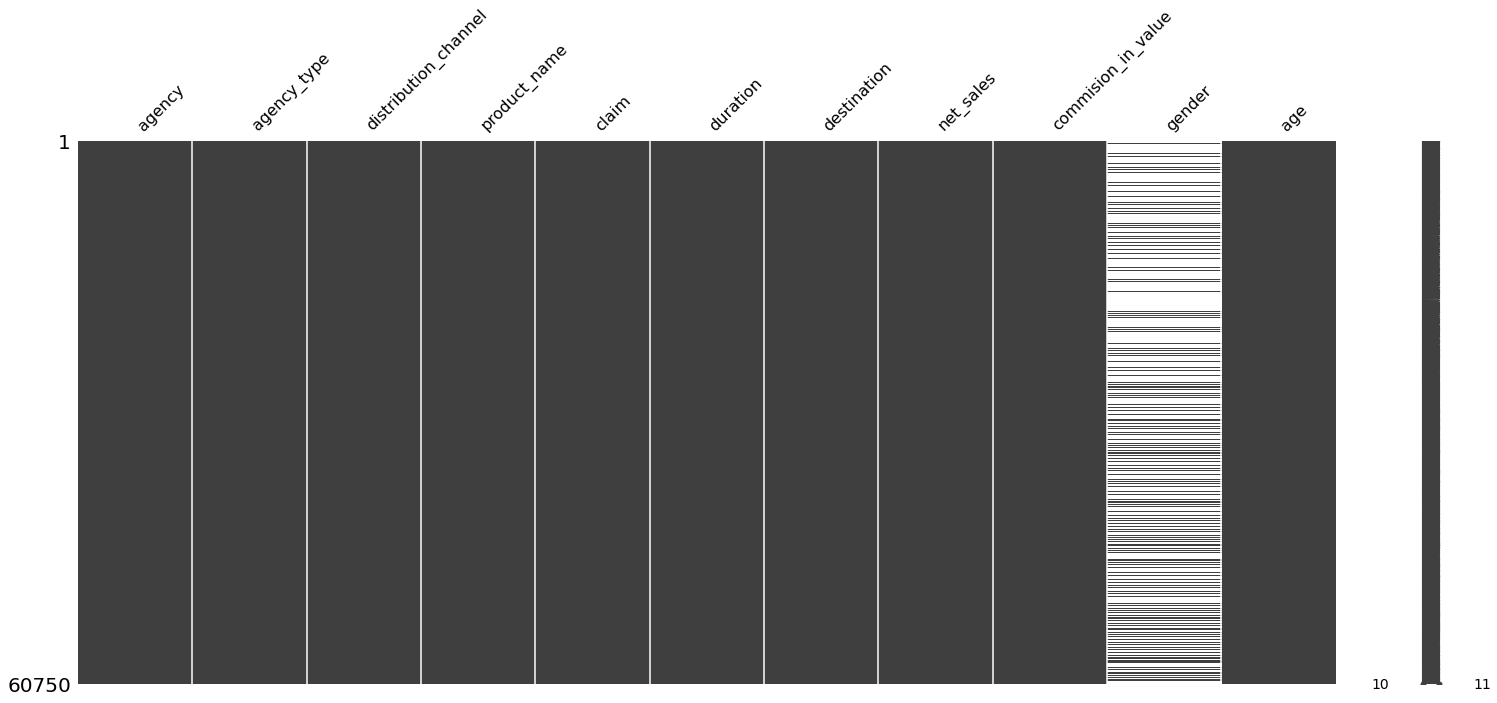

In [14]:
# Now with the more obvious ones out of the way, let's check for NAs

missingno.matrix(df)
print(df["gender"].isnull().sum() / df.shape[0])

# decision to drop gender column since ~70% of the values are missing. 
# Throw this into the "let's not include this" bucket

In [15]:
df = df.drop(["gender"], axis=1)

# Distribution of features

- Can look at this numerically with the UDF created, or visually with histograms/KDE plots
- Links back to outliers, class imbalance bucket
- Here we can make some notes on potential scaling options as well
- For regression problems, plotting the histogram/KDE of the response can lead to visual evidence for using parametric methods

### Quick sidetrack to look at a regression example
- Say we wanted to predict net_sales instead
- What I like to do is plot the response with an interactive widget and change a few variables
- This, coupled with a goodness-of-fit test provides a very naive view that a parametric method like a GLM may work with a certain distributional assumption and a link function

In [16]:
def plot_net_sales_kde(age: int) -> None:
    _df = df.loc[df["age"]==age, "net_sales"]
    sns.distplot(
        _df,
        hist=True, 
        kde=True, 
        bins=int(180/5), 
        color="darkblue", 
        hist_kws={ "edgecolor":"black" },
        kde_kws={ "linewidth": 3 }
    )
    
interact(plot_net_sales_kde, age=widgets.IntSlider(value=20))

interactive(children=(IntSlider(value=20, description='age'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_net_sales_kde(age: int) -> None>

#### Okay, back to the main example

- Let's take a look at the distribution of the actual response, claim

In [17]:
print(col_cat_info(df, "claim"))

# Throw this into the class imbalance bucket

{'name': 'claim', 'num_of_cat': 2, 'categories': array([0, 1], dtype=int64), 'ppn': {(0, 0.98), (1, 0.02)}}


# Class imbalance

- Resampling techniques (Over, under, SMOTE)
- Weighting observations
- Trying other algorithms, maybe tree-based methods
- Using different performance metrics i.e Precision/Recall/F1 other than just accuracy

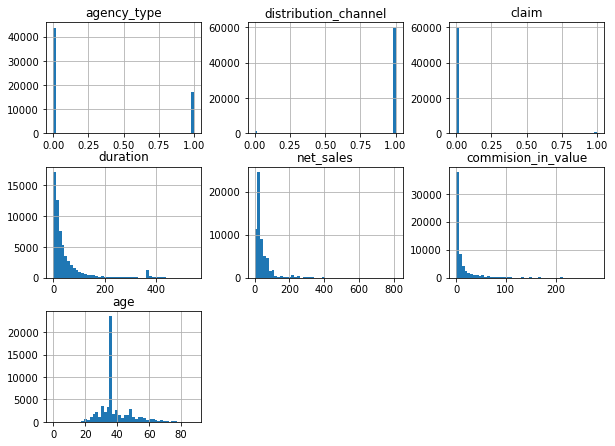

In [18]:
df.hist(figsize=(10, 10), bins=50, layout=(4, 3))
plt.show()
# Note duration, and age dsns
# df.boxplot() is an alternative
# Put these columns into the "need to scale" bucket
# Brief intro to scaling here, more on that in the feature eng. brown bag

In [19]:
df['destination'].value_counts()

SINGAPORE                   12944
THAILAND                     5735
MALAYSIA                     5643
CHINA                        4675
INDONESIA                    3393
                            ...  
TURKS AND CAICOS ISLANDS        1
BARBADOS                        1
SEYCHELLES                      1
MOLDOVA, REPUBLIC OF            1
DOMINICAN REPUBLIC              1
Name: destination, Length: 147, dtype: int64

In [20]:
# Just an example of a binning method, realistically can also use top N net_sales as a cut-off
# The same exercise is also recommended for product_name

dest=df["destination"].value_counts()
dest=dict(dest[:25])
dest=dest.keys()
df.loc[~df["destination"].isin(dest), "destination"] = "Others"
dest=df['destination'].value_counts()
print(dest)

SINGAPORE                    12944
THAILAND                      5735
MALAYSIA                      5643
CHINA                         4675
Others                        3459
INDONESIA                     3393
AUSTRALIA                     3316
PHILIPPINES                   2442
UNITED STATES                 2400
HONG KONG                     2364
INDIA                         2206
JAPAN                         1937
VIET NAM                      1641
KOREA, REPUBLIC OF            1416
UNITED KINGDOM                1210
TAIWAN, PROVINCE OF CHINA     1069
MYANMAR                        793
BRUNEI DARUSSALAM              769
NEW ZEALAND                    492
CAMBODIA                       488
CANADA                         480
FRANCE                         441
GERMANY                        423
ITALY                          402
NETHERLANDS                    327
SPAIN                          285
Name: destination, dtype: int64


# Relationships between columns - Visual

- Scatter matrix
- Histograms by response
- Heat maps, but use "sparingly"

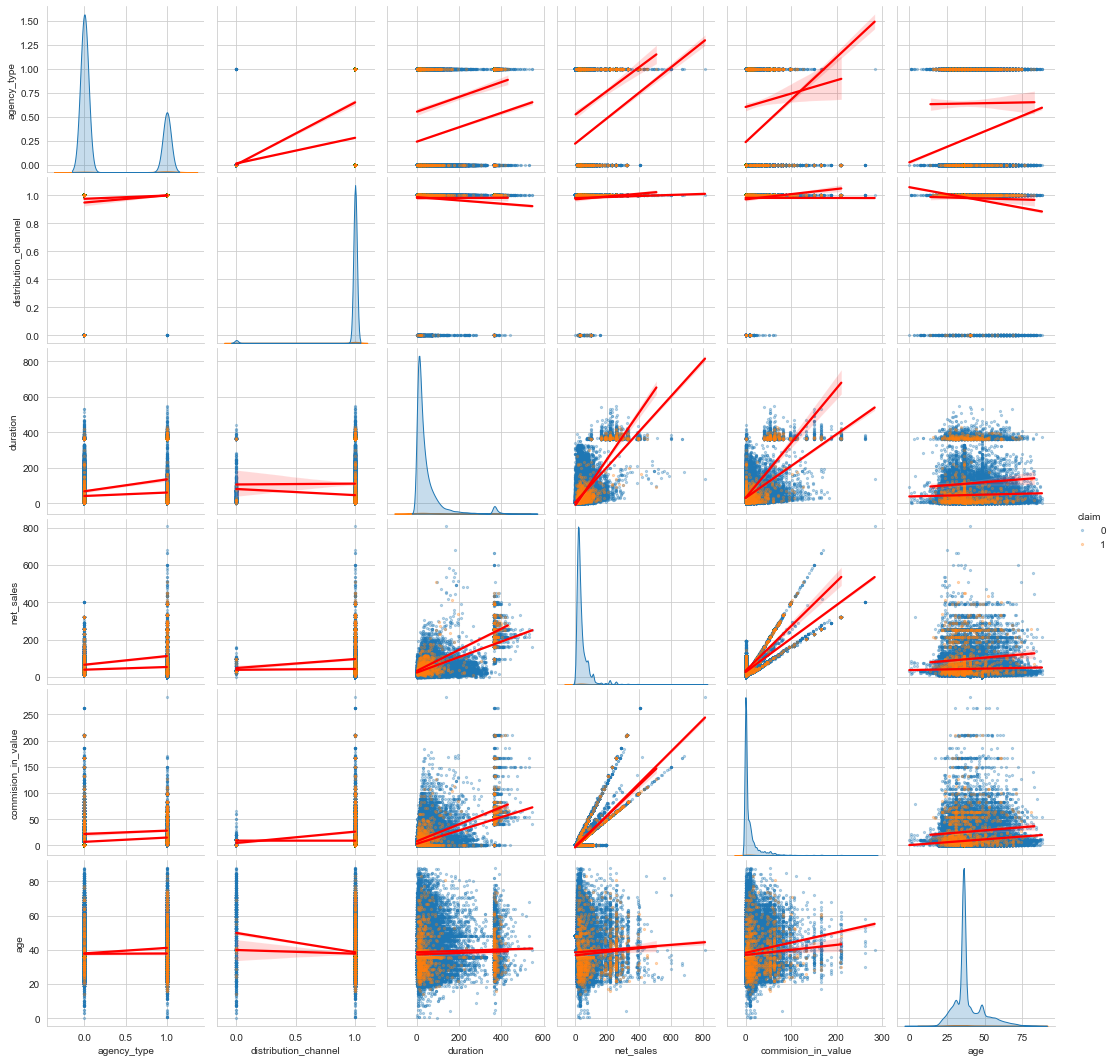

In [21]:
sns.set_style("whitegrid");
g = sns.pairplot(
    df, 
    kind="reg", 
    hue="claim", 
    plot_kws={ "line_kws": { "color": "red" }, "scatter_kws": { "alpha": 0.3, "s": 5 } })
plt.show()

# Here we clearly see that Commision and Net Values are corelated and distributions look same (linearly dependent)
# This is one of the classic examples of "we can probably throw one away"
# But an argument can be made that net_sales/commission are a function of the other features as well
# If this were a pricing exercise, we'd probably not want to use sales/commissions. 
# Since it's basically an exercise on just predicting claim %, can see how net_sales affects claim %
# For now let's put commission_in_value into the "let's exclude bucket"

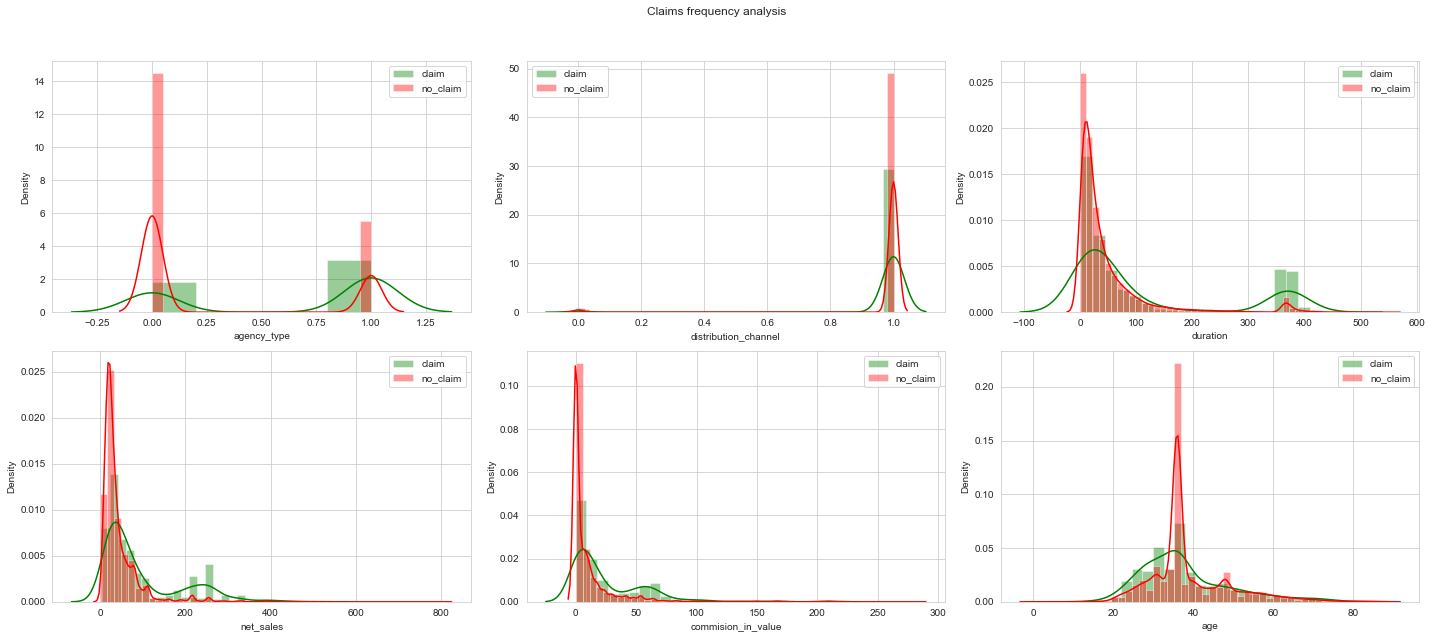

In [22]:
result = pd.DataFrame()
result["claim"] = df.loc[:, "claim"]
fig = plt.figure(figsize = (20, 25))
j = 0
for i in [x for x in df.columns if df[x].dtype != "O" and x != "claim"]:
    plt.subplot(6, 3, j+1)
    j += 1
    sns.distplot(df[i][result["claim"] == 1], color="g", label="claim")
    sns.distplot(df[i][result["claim"] == 0], color="r", label="no_claim")
    plt.legend(loc="best")
fig.suptitle("Claims frequency analysis")
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

# Relationships between columns - Numerical

- Correlation [matrices](https://statistics.laerd.com/statistical-guides/spearmans-rank-order-correlation-statistical-guide.php)
    - Pearsons: Measure linear relationship
    - Spearman: Measures monotonic relationship
    - [Cramer's V](https://www.spss-tutorials.com/cramers-v-what-and-why/): Measures association of 2 categorical variables based on the $\chi^2$ test

In [23]:
df.corr("kendall")

agency_type  distribution_channel     claim  duration  \
agency_type              1.000000              0.080334  0.098932 -0.005363   
distribution_channel     0.080334              1.000000 -0.000631 -0.051738   
claim                    0.098932             -0.000631  1.000000  0.045944   
duration                -0.005363             -0.051738  0.045944  1.000000   
net_sales                0.042909             -0.033702  0.073603  0.229600   
commision_in_value       0.515640             -0.081981  0.091071  0.088919   
age                      0.096867             -0.079514 -0.019520 -0.006260   

                      net_sales  commision_in_value       age  
agency_type            0.042909            0.515640  0.096867  
distribution_channel  -0.033702           -0.081981 -0.079514  
claim                  0.073603            0.091071 -0.019520  
duration               0.229600            0.088919 -0.006260  
net_sales              1.000000            0.323951  0.008170  
commision_in_value     0.323951            1.000000  0.114681  
age                    0.008170            0.114681  1.000000

# Mental summary


- Outliers, scaling, suspicious data
    - duration -> sus, scaling
    - age -> sus, scaling
    - net_sales -> scaling
- Class imbalance
    - response -> model weighting / SMOTE
- Oh let's definitely try to include this
    - destination -> binning
    - product_name -> binning
    - age
    - duration
    - net_sales
    - distribution_channel x age -> create column
    - duration x net_sales -> create column
    - Other interactions maybe?
- Oh this is probably useless
    - gender -> drop column
    - commissions -> drop column

# Pandas profiling

- Tool that attempts to automate the EDA process
- Good as a crutch, but not recommended as a standalone

In [24]:
df.profile_report()